# User intent recognition model

Execution time: ~7m (training included) <br />
Training time: 3m 21s (2 epochs)

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install text-hr

## Data loading

- Define the preprocesor and the base model
- LaBSE 2 base model used: https://tfhub.dev/google/LaBSE/2
- Load the data from published google spreadsheet
- Merge categories and Normalize data within them

In [4]:
import tensorflow as tf
import tensorflow_text as tft
import tensorflow_hub as tfh
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Text preprocessor for bert based models
preprocessor = tfh.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2')

# Language Agnostic BERT sentence encoder
model = tfh.KerasLayer('https://tfhub.dev/google/LaBSE/2')

In [6]:
# Read the data from published excel file
data = pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vRKZziYPXXp-C3-GWkzAdPaWBRgRidy5OYMwt8RCDEzFLczk4MG8hi3e2Glc7EfEw/pub?output=xlsx')

In [ ]:
data.info(verbose=True)

In [8]:
# Text -> hrvatski text
# Action -> vrsta akcije (ne koristim ovdje)
# Intent -> 3 classes of intents
# Intent -> 5 classes of intents
# g_translation -> translation hr->eng using google translator
# h_translation -> translation hr->eng manualy   
columns = ['text', 'action', 'intent', 'intent02', 'g_translation', 'h_translation']
data.columns = columns

### Category merging

In [9]:
# Mark "Out of domain" categories
data['intent02'][data['intent02'] == 'studomat_problemi'] = 'OOD'
data['intent02'][data['intent02'] == 'status_studenta'] = 'OOD'

In [10]:
# Convert categories to codes
data['intent02'] = data['intent02'].astype('category')
data['intent_codes'] = data['intent02'].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

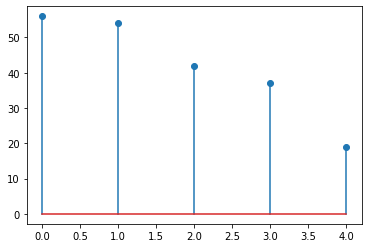

In [11]:
# Display the distribution of codes
values = data['intent02'].value_counts()
plt.stem(values)

### Normalize data

In [12]:
upis_data = data[data['intent02'] == 'upis_na_sveuciliste']
upis_data = upis_data.sample(frac=1, random_state=1234)
upis_data = upis_data.sample(40)
upis_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 17 to 191
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   text           40 non-null     object  
 1   action         40 non-null     object  
 2   intent         40 non-null     object  
 3   intent02       40 non-null     category
 4   g_translation  40 non-null     object  
 5   h_translation  40 non-null     object  
 6   intent_codes   40 non-null     int8    
dtypes: category(1), int8(1), object(5)
memory usage: 2.2+ KB


In [13]:
ood_data = data[data['intent02'] == 'OOD']
ood_data = ood_data.sample(frac=1, random_state=1234)
ood_data = ood_data.sample(40)
ood_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 180 to 186
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   text           40 non-null     object  
 1   action         40 non-null     object  
 2   intent         40 non-null     object  
 3   intent02       40 non-null     category
 4   g_translation  40 non-null     object  
 5   h_translation  40 non-null     object  
 6   intent_codes   40 non-null     int8    
dtypes: category(1), int8(1), object(5)
memory usage: 2.2+ KB


In [14]:
data2 = data[(data['intent02'] != 'OOD') & (data['intent02'] != 'upis_na_sveuciliste')]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 54 to 207
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   text           98 non-null     object  
 1   action         98 non-null     object  
 2   intent         98 non-null     object  
 3   intent02       98 non-null     category
 4   g_translation  98 non-null     object  
 5   h_translation  98 non-null     object  
 6   intent_codes   98 non-null     int8    
dtypes: category(1), int8(1), object(5)
memory usage: 5.0+ KB


In [15]:
data2 = data2.append(upis_data, ignore_index=True)
data2 = data2.append(ood_data, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

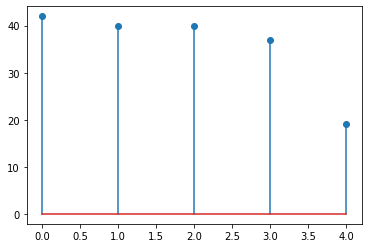

In [16]:
values = data2['intent02'].value_counts()
plt.stem(values)

In [17]:
data = data2

## Text preprocessing

1. Remove punctuation
2. Lowercase the text
3. Apply tokenization
4. Remove stopwords
5. Apply lemmatizer

In [ ]:
import string
import re
import nltk
import text_hr

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [26]:
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenization(text):
    return re.split(r"\s+",text)

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    return [i for i in text if i not in stopwords]

porter_stemmer = PorterStemmer()
def stemming(text):
    return [porter_stemmer.stem(word) for word in text]

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

In [27]:
data['g_translation'] = data['g_translation']\
    .apply(lambda x: remove_punctuation(x))\
    .apply(lambda x: x.lower())\
    .apply(lambda x: tokenization(x))\
    .apply(lambda x: remove_stopwords(x))\
    .apply(lambda x: lemmatizer(x))

In [ ]:
data[['text', 'g_translation']].head()

In [29]:
stop_words_list_hr = []
for word_base, l_key, cnt, _suff_id, wform_key, wform in text_hr.get_all_std_words():
    if word_base is not None: stop_words_list_hr.append(word_base)
    if wform is not None: stop_words_list_hr.append(wform)

In [ ]:
stop_words_list_hr = list(dict.fromkeys(stop_words_list_hr))
len(stop_words_list_hr)

In [31]:
def remove_stopwords_hr(text):
    output = [i for i in text if i not in stop_words_list_hr]
    return output

In [32]:
data['text'] = data['text'].apply(lambda x: remove_stopwords_hr(x))

In [ ]:
data[['text','g_translation', 'h_translation']].head()

In [ ]:
data['text'] = data['text'].str.join(" ")
data['g_translation'] = data['g_translation'].str.join(" ")
data['text'].head()

In [ ]:
data.head()

## Split validation and training data

Train 75%, validation 25%

In [ ]:
codes = data['intent_codes'].unique()

# Variable to understand the meaning behind codes
CODES_REPR = data[["intent_codes", "intent02"]].drop_duplicates().sort_values("intent_codes")

In [36]:
preprocessed_validation_data = pd.DataFrame(columns=data.columns)
preprocessed_train_data = pd.DataFrame(columns=data.columns)

for c in codes:
    sample = data[data['intent_codes'] == c]
    sample = sample.sample(frac=1)
    val = sample.sample(frac=0.25)
    train = pd.concat([sample, val]).drop_duplicates(keep=False)
    preprocessed_validation_data = preprocessed_validation_data.append(val, ignore_index=True)
    preprocessed_train_data = preprocessed_train_data.append(train, ignore_index=True)

In [37]:
# Preprocessed google translation data
train_data_eng = preprocessed_train_data[['g_translation', 'intent_codes']]
train_data_eng.columns = ['text', 'intent_codes']

validation_data_eng = preprocessed_validation_data[['g_translation', 'intent_codes']]
validation_data_eng.columns = ['text', 'intent_codes']

In [ ]:
def df_to_dataset(df, shuffle=True, batch_size=16):
    df = df.copy()
    labels = df.pop('intent_codes')
    lables_cat = tf.keras.utils.to_categorical(labels, 5)
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), lables_cat))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    return dataset

In [38]:
train_data_eng = df_to_dataset(train_data_eng)
validation_data_eng = df_to_dataset(validation_data_eng)

## Model definition and training

2 epochs training (testing purposes)

In [ ]:
# Model builder
def model_build():
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoded_input = preprocessor(inputs)
    encoder_outputs = model(encoded_input)

    x = encoder_outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(x)
    
    return tf.keras.Model(inputs, outputs)

# Build a model with preprocessed data 
model_eng = model_build()
model_eng.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = tf.keras.metrics.CategoricalAccuracy()
)

eng_history = model_eng.fit(
    train_data_eng,
    epochs = 2,
    batch_size = 16,
    validation_data = validation_data_eng
)

# Using the model

In progress...

In [89]:
def predict_intent(text: str) -> str:
    """ Predict the text intent based on the abovetrained model """
    y_pred = model_eng.predict([text])
    return CODES_REPR[CODES_REPR["intent_codes"] == y_pred.argmax()].iloc[0]["intent02"]

In [90]:
predict_intent("How to submit the final paper")

1/1 [==============================] - 1s 719ms/step


'prijava_zavrsnog'